###Define module and for VQVAE

In [1]:
!pip install tensorboardX

     |████████████████████████████████| 122kB 13.9MB/s 


In [2]:
import torch
from torch.autograd import Function
from torchsummary import summary

class VectorQuantization(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        with torch.no_grad():
            embedding_size = codebook.size(1)
            inputs_size = inputs.size()
            inputs_flatten = inputs.view(-1, embedding_size)

            codebook_sqr = torch.sum(codebook ** 2, dim=1)
            inputs_sqr = torch.sum(inputs_flatten ** 2, dim=1, keepdim=True)

            # Compute the distances to the codebook
            distances = torch.addmm(codebook_sqr + inputs_sqr,
                inputs_flatten, codebook.t(), alpha=-2.0, beta=1.0)

            _, indices_flatten = torch.min(distances, dim=1)
            indices = indices_flatten.view(*inputs_size[:-1])
            ctx.mark_non_differentiable(indices)

            return indices

    @staticmethod
    def backward(ctx, grad_output):
        raise RuntimeError('Trying to call `.grad()` on graph containing '
            '`VectorQuantization`. The function `VectorQuantization` '
            'is not differentiable. Use `VectorQuantizationStraightThrough` '
            'if you want a straight-through estimator of the gradient.')

class VectorQuantizationStraightThrough(Function):
    @staticmethod
    def forward(ctx, inputs, codebook):
        indices = vq(inputs, codebook)
        indices_flatten = indices.view(-1)
        ctx.save_for_backward(indices_flatten, codebook)
        ctx.mark_non_differentiable(indices_flatten)

        codes_flatten = torch.index_select(codebook, dim=0,
            index=indices_flatten)
        codes = codes_flatten.view_as(inputs)

        return (codes, indices_flatten)

    @staticmethod
    def backward(ctx, grad_output, grad_indices):
        grad_inputs, grad_codebook = None, None

        if ctx.needs_input_grad[0]:
            # Straight-through estimator
            grad_inputs = grad_output.clone()
        if ctx.needs_input_grad[1]:
            # Gradient wrt. the codebook
            indices, codebook = ctx.saved_tensors
            embedding_size = codebook.size(1)

            grad_output_flatten = (grad_output.contiguous()
                                              .view(-1, embedding_size))
            grad_codebook = torch.zeros_like(codebook)
            grad_codebook.index_add_(0, indices, grad_output_flatten)

        return (grad_inputs, grad_codebook)

vq = VectorQuantization.apply
vq_st = VectorQuantizationStraightThrough.apply
__all__ = [vq, vq_st]

In [3]:
#module
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence


def to_scalar(arr):
    if type(arr) == list:
        return [x.item() for x in arr]
    else:
        return arr.item()


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1./K, 1./K)

    def forward(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        latents = vq(z_e_x_, self.embedding.weight)
        return latents

    def straight_through(self, z_e_x):
        z_e_x_ = z_e_x.permute(0, 2, 3, 1).contiguous()
        z_q_x_, indices = vq_st(z_e_x_, self.embedding.weight.detach())
        z_q_x = z_q_x_.permute(0, 3, 1, 2).contiguous()

        z_q_x_bar_flatten = torch.index_select(self.embedding.weight,
            dim=0, index=indices)
        z_q_x_bar_ = z_q_x_bar_flatten.view_as(z_e_x_)
        z_q_x_bar = z_q_x_bar_.permute(0, 3, 1, 2).contiguous()

        return z_q_x, z_q_x_bar


class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(dim, dim//4, 3, 1, 1),
            nn.BatchNorm2d(dim//4),
            nn.ReLU(True),
            nn.Conv2d(dim//4, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, dim, K=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim//4, 4, 2, 1),
            nn.BatchNorm2d(dim//4),
            nn.ReLU(True),
            nn.Conv2d(dim//4, dim//2, 4, 2, 1),
            nn.BatchNorm2d(dim//2),
            nn.ReLU(True),
            nn.Conv2d(dim//2, dim, 4, 2, 1),
            ResBlock(dim),
            ResBlock(dim),
        )

        self.codebook = VQEmbedding(K, dim)

        self.decoder = nn.Sequential(
            ResBlock(dim),
            ResBlock(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim//2, 4, 2, 1),
            nn.BatchNorm2d(dim//2),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim//2, dim//4, 4, 2, 1),
            nn.BatchNorm2d(dim//4),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim//4, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.codebook(z_e_x)
        return latents

    def decode(self, latents):
        z_q_x = self.codebook.embedding(latents).permute(0, 3, 1, 2)  # (B, D, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde

    def forward(self, x):
        z_e_x = self.encoder(x)
        z_q_x_st, z_q_x = self.codebook.straight_through(z_e_x)
        x_tilde = self.decoder(z_q_x_st)
        return x_tilde, z_e_x, z_q_x

In [4]:
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid

from tensorboardX import SummaryWriter

def train(data_loader, model, optimizer, args, writer):
    for images, _ in data_loader:
        images = images.to(args.device)

        optimizer.zero_grad()
        x_tilde, z_e_x, z_q_x = model(images)

        # Reconstruction loss
        loss_recons = F.mse_loss(x_tilde, images)
        # Vector quantization objective
        loss_vq = F.mse_loss(z_q_x, z_e_x.detach())
        # Commitment objective
        loss_commit = F.mse_loss(z_e_x, z_q_x.detach())

        loss = loss_recons + loss_vq + args.beta * loss_commit
        loss.backward()

        # Logs
        writer.add_scalar('loss/train/reconstruction', loss_recons.item(), args.steps)
        writer.add_scalar('loss/train/quantization', loss_vq.item(), args.steps)

        optimizer.step()
        args.steps += 1

def test(data_loader, model, args, writer):
    with torch.no_grad():
        loss_recons, loss_vq = 0., 0.
        for images, _ in data_loader:
            images = images.to(args.device)
            x_tilde, z_e_x, z_q_x = model(images)
            loss_recons += F.mse_loss(x_tilde, images)
            loss_vq += F.mse_loss(z_q_x, z_e_x)

        loss_recons /= len(data_loader)
        loss_vq /= len(data_loader)

    # Logs
    writer.add_scalar('loss/test/reconstruction', loss_recons.item(), args.steps)
    writer.add_scalar('loss/test/quantization', loss_vq.item(), args.steps)

    return loss_recons.item(), loss_vq.item()

def generate_samples(images, model, args):
    with torch.no_grad():
        images = images.to(args.device)
        x_tilde, _, _ = model(images)
    return x_tilde

###Load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import glob
import cv2

import numpy as np
from scipy.stats import norm

#FOLDER_PATH = "path of a folder of the training images"
FOLDER_PATH = "/content/drive/MyDrive/Colab Notebooks/Steel Microstructure/data40A10JPEG/"

x=glob.glob('{}/*.jpeg'.format(FOLDER_PATH))  

image = []
thres = []
for i in x:
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  img = cv2.resize(img, (256*4, 192*4)) 
  for j in range(11):
    for k in range(15):
      cimg = img[64*j:64*j+128,64*k:64*k+128]
      image.append(cimg)
      image.append(cv2.flip(cimg, 1))#左右反転した画像もデータセットに追加

In [12]:
#For training dataset with corresponding cooling rates
from PIL import Image
import random
import math

image = np.asarray(image)
print(image.shape)

#The natural logarithm of the cooling rates
y = np.full(int(len(image)/4), math.log(1.0))
y = np.append(y, np.full(int(len(image)/4), math.log(3.0)))
y = np.append(y, np.full(int(len(image)/4), math.log(10.0)))
y = np.append(y, np.full(int(len(image)/4), math.log(30.0)))
y = np.reshape(y, (len(image), 1))
print(y.shape)

#The natural logarithm of the cooling rates without 3.0℃/s
#y = np.full(int(len(image)/3), math.log(1.0))
#y = np.append(y, np.full(int(len(image)/3), math.log(10.0)))
#y = np.append(y, np.full(int(len(image)/3), math.log(30.0)))
#y = np.reshape(y, (len(image), 1))
#print(y.shape)

arr = np.arange(image.shape[0])
random.shuffle(arr)
(tx_train), (tx_test) = image[arr[:]],image[arr[-5000:]]
(ty_train), (ty_test) = y[arr[:]], y[arr[-5000:]] 

tx_train = tx_train.astype('float32') / 255.
tx_train = np.reshape(tx_train, (len(tx_train), 128, 128, 1)) 
ty_train = ty_train.astype('float32')
print(tx_train.shape)
print(ty_train.shape)

tx_test = tx_test.astype('float32') / 255.
tx_test = np.reshape(tx_test, (len(tx_test), 128, 128, 1))
ty_test = ty_test.astype('float32')
print(tx_test.shape)
print(ty_test.shape)

tx_train = np.transpose(tx_train, (0,3,1,2))
print(tx_train.shape)
tx_test = np.transpose(tx_test, (0,3,1,2))
print(tx_test.shape)

(52800, 128, 128)
(52800, 1)
(52800, 128, 128, 1)
(52800, 1)
(5000, 128, 128, 1)
(5000, 1)
(52800, 1, 128, 128)
(5000, 1, 128, 128)


In [8]:
tx_train = torch.tensor(tx_train)
ty_train = torch.tensor(ty_train)
tx_test = torch.tensor(tx_test)
ty_test = torch.tensor(ty_test)

In [9]:
from torch.utils.data import  Dataset, TensorDataset

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)
        y = self.tensors[1][index]
        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [10]:
transform = transforms.Compose([
            transforms.Normalize((0.5,), (0.5,)) # for gray
        ])

train_dataset = CustomTensorDataset(tensors=(tx_train, ty_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(tx_test, ty_test), transform=transform)
valid_dataset = test_dataset

###VQVAE training

In [ ]:
def main_vqvae(arg, Restart = False):
    writer = SummaryWriter('./logs/{0}'.format(args.output_folder))
    save_filename = './models/{0}'.format(args.output_folder)

    # Define the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.num_workers, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=args.batch_size, shuffle=False, drop_last=True,
        num_workers=args.num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=16, shuffle=True)

    num_channels = 1

    # Fixed images for Tensorboard
    fixed_images, _ = next(iter(test_loader))
    fixed_grid = make_grid(fixed_images, nrow=8, range=(-1, 1), normalize=True)
    writer.add_image('original', fixed_grid, 0)

    model = VectorQuantizedVAE(num_channels, args.hidden_size, args.k).to(args.device)
    summary(model, (1,128,128))

    if Restart:
        FILE_PATH = 'file path of the pretrained VQVAE for restarting training'
        with open(FILE_PATH, 'rb') as f:
            state_dict = torch.load(f)
            model.load_state_dict(state_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    # Generate the samples first once
    reconstruction = generate_samples(fixed_images, model, args)
    grid = make_grid(reconstruction.cpu(), nrow=8, range=(-1, 1), normalize=True)
    writer.add_image('reconstruction', grid, 0)

    best_loss = -1.
    for epoch in range(args.num_epochs):
        train(train_loader, model, optimizer, args, writer)
        loss, _ = test(valid_loader, model, args, writer)

        reconstruction = generate_samples(fixed_images, model, args)
        grid = make_grid(reconstruction.cpu(), nrow=8, range=(-1, 1), normalize=True)
        writer.add_image('reconstruction', grid, epoch + 1)

        if (epoch == 0) or (loss < best_loss):
            best_loss = loss
            with open('{0}/best.pt'.format(save_filename), 'wb') as f:
                torch.save(model.state_dict(), f)
        with open('{0}/model_{1}.pt'.format(save_filename, epoch + 1), 'wb') as f:
            torch.save(model.state_dict(), f)

In [ ]:
# For VQVAE
import argparse
import os
import multiprocessing as mp

class args():
    def __init__(self):
        self.data_folder =  "./"
        self.hidden_size = 128
        self.k = 512
        self.batch_size = 256
        self.num_epochs = 300
        self.lr = 1e-3 #2e-4
        self.beta = 1.0
        self.output_folder = 'vqvae'
        self.num_workers = 0
        self.device = 'cuda'
args = args()

# Create logs and models folder if they don't exist
if not os.path.exists('./logs'):
     os.makedirs('./logs')
if not os.path.exists('./models'):
    os.makedirs('./models')
# Device
args.device = torch.device(args.device
    if torch.cuda.is_available() else 'cpu')
# Slurm
if 'SLURM_JOB_ID' in os.environ:
    args.output_folder += '-{0}'.format(os.environ['SLURM_JOB_ID'])
if not os.path.exists('./models/{0}'.format(args.output_folder)):
    os.makedirs('./models/{0}'.format(args.output_folder))
args.steps = 0

main_vqvae(args)
#main_vqvae(args, Restart = True) # For restarting training of VQVAE

###Tensor board to monitor training

In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
%reload_ext tensorboard

In [ ]:
tensorboard --logdir ./

###For PixelCNN

In [ ]:
class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return F.tanh(x) * F.sigmoid(y)


class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True, n_classes=1):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual
        self.dim = dim

        self.class_cond_embedding = nn.Linear(in_features=n_classes, out_features=2 * dim)
        

        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)
        self.vert_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)
        self.horiz_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()  # Mask final row
        self.horiz_stack.weight.data[:, :, :, -1].zero_()  # Mask final column

    def forward(self, x_v, x_h, h):
        if self.mask_type == 'A':
            self.make_causal()

        h = self.class_cond_embedding(h)
        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert + h[:, :, None, None])

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz + h[:, :, None, None])
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h


class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15, n_classes=1):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input
        self.embedding = nn.Embedding(input_dim, dim)

        # Building the PixelCNN layer by layer
        self.layers = nn.ModuleList()

        # Initial block with Mask-A convolution
        # Rest with Mask-B convolutions
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual, n_classes)
            )

        # Add the output layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

        self.apply(weights_init)

    def forward(self, x, label):
        shp = x.size() + (-1, )
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, W)

        x_v, x_h = (x, x)
        for i, layer in enumerate(self.layers):
            x_v, x_h = layer(x_v, x_h, label)

        return self.output_conv(x_h)

    def generate(self, label, shape=(16, 16), batch_size=64):
        param = next(self.parameters())
        x = torch.zeros(
            (batch_size, *shape),
            dtype=torch.int64, device=param.device
        )

        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x, label)
                probs = F.softmax(logits[:, :, i, j], -1)
                #Ramdom sampling
                x.data[:, i, j].copy_(
                    probs.multinomial(1).squeeze().data
                )
        return x

In [ ]:
# Pixel CNN for prior
import numpy as np
import torch
import torch.nn.functional as F
import json
from torchvision import transforms
from torchvision.utils import save_image, make_grid


def train(data_loader, model, prior, optimizer, args, writer):
    for images, labels in data_loader:
        with torch.no_grad():
            images = images.to(args.device)
            latents = model.encode(images) #output index map !before embedding!
            latents = latents.detach()

        labels = labels.to(args.device)
        logits = prior(latents, labels)
        logits = logits.permute(0, 2, 3, 1).contiguous()

        optimizer.zero_grad()
        loss = F.cross_entropy(logits.view(-1, args.k),
                               latents.view(-1))
        loss.backward()

        # Logs
        writer.add_scalar('loss/train', loss.item(), args.steps)

        optimizer.step()
        args.steps += 1

def test(data_loader, model, prior, args, writer):
    with torch.no_grad():
        loss = 0.
        for images, labels in data_loader:
            images = images.to(args.device)
            labels = labels.to(args.device)

            latents = model.encode(images)
            latents = latents.detach()
            logits = prior(latents, labels)
            logits = logits.permute(0, 2, 3, 1).contiguous()
            loss += F.cross_entropy(logits.view(-1, args.k),
                                    latents.view(-1))

        loss /= len(data_loader)

    # Logs
    writer.add_scalar('loss/valid', loss.item(), args.steps)

    return loss.item()

def main_prior(args, Restart = False):
    writer = SummaryWriter('./logs/{0}'.format(args.output_folder))
    save_filename = './models/{0}/prior.pt'.format(args.output_folder)

    # Define the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.num_workers, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
        batch_size=args.batch_size, shuffle=False, drop_last=True,
        num_workers=args.num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=16, shuffle=True)
    
    num_channels=1

    fixed_images, _ = next(iter(test_loader))
    fixed_grid = make_grid(fixed_images, nrow=8, range=(-1, 1), normalize=True)
    writer.add_image('original', fixed_grid, 0)

    model = VectorQuantizedVAE(num_channels, args.hidden_size_vae, args.k).to(args.device)
    with open(args.model, 'rb') as f:
        state_dict = torch.load(f)
        model.load_state_dict(state_dict)
    model.eval()

    # n_classes : dimension of the given condition.
    # For example, since the cooling rate is one dimensional condition, n_classes=1
    prior = GatedPixelCNN(args.k, args.hidden_size_prior,
        args.num_layers, n_classes=1).to(args.device) 

    if Restart: #再学習
        FILE_PATH = 'file path of the pretrained PixelCNN for restarting training'
        with open(FILE_PATh, 'rb') as f:
            state_dict = torch.load(f)
            prior.load_state_dict(state_dict)

    optimizer = torch.optim.Adam(prior.parameters(), lr=args.lr)

    best_loss = -1.
    for epoch in range(args.num_epochs):
        train(train_loader, model, prior, optimizer, args, writer)
        # The validation loss is not properly computed since
        # the classes in the train and valid splits of Mini-Imagenet
        # do not overlap.
        loss = test(valid_loader, model, prior, args, writer)

        if (epoch == 0) or (loss < best_loss):
            best_loss = loss
            with open(save_filename, 'wb') as f:
                torch.save(prior.state_dict(), f)
        with open('./models/prior/prior_{0}.pt'.format(epoch + 1), 'wb') as f:
            torch.save(prior.state_dict(), f)

### Pixel CNN training

In [ ]:
import argparse
import os
import multiprocessing as mp

class args2(): #名前変更
    def __init__(self):
        self.data_folder = './' #保存先
        #self.model = 'File path of the pretrained VQVAE for training PixelCNN'
        self.model = '/content/drive/MyDrive/Colab Notebooks/Steel Microstructure/Model/VQVAE/A10/Trial_20210130_log/model_135.pt'
        self.hidden_size_vae = 128
        self.hidden_size_prior = 64
        self.k = 512   #要確認
        self.num_layers = 15
        self.batch_size = 128
        self.num_epochs = 200
        self.lr = 3e-4
        self.output_folder = 'prior'
        self.num_workers = 0
        self.device = 'cuda'
args = args2()


In [ ]:
#Train Pixel CNN
# Create logs and models folder if they don't exist
if not os.path.exists('./logs'):
     os.makedirs('./logs')
if not os.path.exists('./models'):
    os.makedirs('./models')
# Device
args.device = torch.device(args.device
    if torch.cuda.is_available() else 'cpu')
# Slurm
if 'SLURM_JOB_ID' in os.environ:
    args.output_folder += '-{0}'.format(os.environ['SLURM_JOB_ID'])
if not os.path.exists('./models/{0}'.format(args.output_folder)):
    os.makedirs('./models/{0}'.format(args.output_folder))
args.steps = 0

main_prior(args)
#main_prior(args, Restart = True)

###Load model

In [ ]:
prior = GatedPixelCNN(args.k, args.hidden_size_prior, args.num_layers, n_classes=1).to(args.device)
#with open('/content/models/prior/prior.pt', 'rb') as f:
with open('/content/drive/MyDrive/Colab Notebooks/Steel Microstructure/Model/VQVAE/A10/Trial_20210130_log/prior_116.pt', 'rb') as f:
    state_dict = torch.load(f)
    prior.load_state_dict(state_dict)
prior.eval()

model = VectorQuantizedVAE(1, args.hidden_size_vae, args.k).to(args.device)
#with open(args.model, 'rb') as f:
with open('/content/drive/MyDrive/Colab Notebooks/Steel Microstructure/Model/VQVAE/A10/Trial_20210130_log/model_135.pt', 'rb') as f:
     state_dict = torch.load(f)
     model.load_state_dict(state_dict)
model.eval()

###Visualization of sampled images corresponding to cooloing rates

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


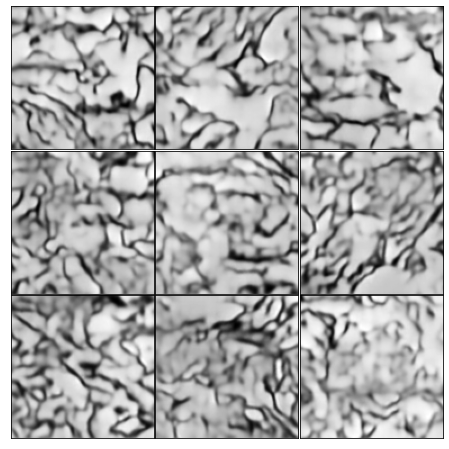

In [ ]:
import matplotlib.pyplot as plt
import math

cooling_rate= 3.0
velocity = math.log(cooling_rate)
batch_size = 9

label = np.full((batch_size,1), velocity).astype('float32')
label = torch.from_numpy(label).clone()
label = label.to('cuda')
feature = prior.generate(label, batch_size=batch_size)
image = model.decode(feature)

fig = plt.figure(figsize=(3, 3))
fig.subplots_adjust(left=0, right=2, bottom=0, top=2, hspace=0.01, wspace=0.01)

for i in range(batch_size):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(image.cpu().detach().numpy()[i].reshape((128,128)), cmap='gray')

In [ ]:
#Save image
FOLDER_PATH = "path of the folder to store the generated images"

for i in range(0, batch_size, 1):
    im = image[i].to('cpu').detach().numpy().copy()
    im = im.reshape((128,128))
    im = (im+1.0)*127.5

    cv2.imwrite(FOLDER_PATH +str(cooling_rate)+'_sample_'+str(i)+'.png', im)

In [ ]:
#To binarize image and to show the binarized images
x=glob.glob('{}/*.png'.format("The path of the folder to store the generated images"))
image = []

for i in x:
  img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
  retval, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  image.append(img)

image = np.asarray(image)
print(image.shape)

fig = plt.figure(figsize=(4, 4))
fig.subplots_adjust(left=0, right=2, bottom=0, top=2, hspace=0.01, wspace=0.01)

for i in range(batch_size):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(image[i].reshape((128,128)), cmap='gray')

In [ ]:
# Calculation of the ferrite volume fraction 
# Import image data and binarize them using Otsu's method

import cv2
import numpy as np
import glob

FOLDER_PATH = 'The folder to store the generated images'

velocity_list = np.zeros(4)
velocity_list[0] = 1.0
velocity_list[1] = 3.0
velocity_list[2] = 10.0
velocity_list[3] = 30.0
image = []
image_sample = []

image_original = []
image_original2 = []

for velocity in velocity_list:
   x_sample=glob.glob('{}/*.png'.format(FOLDER_PATH))
   
   print(str(velocity)+ " is done")
   ind = 0

   for i in x:
     img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
     image_original.append(img)
     ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Otsu's method
     
     #print(ind)
     ind += 1
     image.append(img)
  
   ind =0

   for i in x_sample:
     img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
     image_original2.append(img)
     ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
     
     #print(ind)
     ind += 1

     image_sample.append(img)

image = np.asarray(image)
image_sample = np.asarray(image_sample)

image_original = np.asarray(image_original)
image_original2 = np.asarray(image_original2)

sum_list =[]
sum_list_sample =[]

for i in range(image.shape[0]):
    img = image[i]/255.
    sum = np.sum(img)
    sum_list.append((sum/(128*128))*100.)  # white ratio

for i in range(image_sample.shape[0]):
    img = image_sample[i]/255.
    sum = np.sum(img)
    sum_list_sample.append((sum/(128*128))*100.)  # white ratio

print(len(sum_list))
print(len(sum_list_sample))

1.0 is done
3.0 is done
10.0 is done
30.0 is done
4000
4000


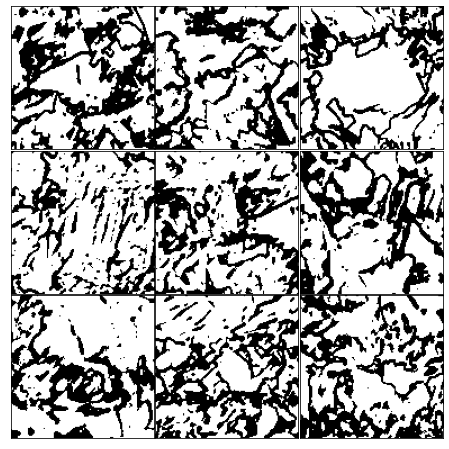

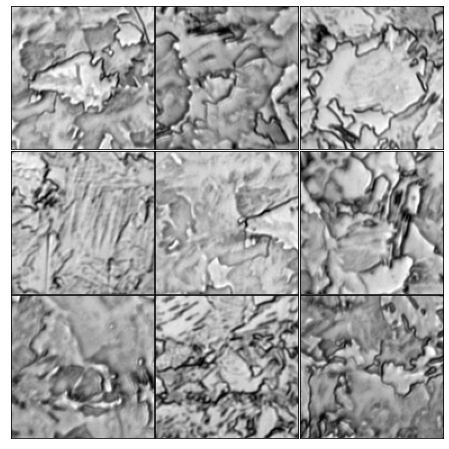

In [ ]:
fig = plt.figure(figsize=(3, 3))
fig.subplots_adjust(left=0, right=2, bottom=0, top=2, hspace=0.01, wspace=0.01)

fig2 = plt.figure(figsize=(3, 3))
fig2.subplots_adjust(left=0, right=2, bottom=0, top=2, hspace=0.01, wspace=0.01)


# Show the example images
for i in range(9):
    ax1 = fig.add_subplot(3
                          , 3, i + 1, xticks=[], yticks=[])
    ax2 = fig2.add_subplot(3, 3, i + 1, xticks=[], yticks=[])

    ax1.imshow(image[i].reshape((128,128)), cmap='gray')
    ax2.imshow(image_original[i].reshape((128,128)), cmap='gray')

In [ ]:
# For calculation of the averaged grain sizes
size_original = []
size_sample = []

cross_point = 0
cross_point2 = 0
cross_point_tmp = 0
index = 0

pixel_length = 0.34

for img in image:
  if index %100 ==0:
    print(str(index) + " is done")

  for i in range(128-1):
    for j in range(128-1):
      if img[i,j]==255 and img[i,j+1]==0:
        cross_point_tmp+=1
      if img[i,j]==0 and img[i,j+1]==255:
        cross_point_tmp+=1
    
    if cross_point_tmp%2 == 1:
      cross_point += (cross_point_tmp+1)/2
    elif img[i,0]==255:
      cross_point += (cross_point_tmp+2)/2
    elif img[i,0]==0:
      cross_point += (cross_point_tmp-2)/2
    cross_point_tmp=0

  for j in range(128-1):
    for i in range(128-1):
      if img[i,j]==255 and img[i+1,j]==0:
        cross_point_tmp+=1
      if img[i,j]==0 and img[i+1,j]==255:
        cross_point_tmp+=1
    
    if cross_point_tmp%2 == 1:
      cross_point2 += (cross_point_tmp+1)/2
    elif img[0,j]==255:
      cross_point2 += (cross_point_tmp+2)/2
    elif img[0,j]==0:
      cross_point2 += (cross_point_tmp-2)/2
    cross_point_tmp=0

  if cross_point*cross_point2==0:
    print("cross_point is zero!")
    size_original.append(0.)
  else:
    size_original.append(128*128*(sum_list[index]/100.*pixel_length)*(1/cross_point+1/cross_point2)/2)
  cross_point=0
  cross_point2=0

  index +=1

index=0
cross_point=0
cross_point2=0

for img in image_sample:
  if index %100 ==0:
    print(str(index) + " is done")

  for i in range(128-1):
    for j in range(128-1):
      if img[i,j]==255 and img[i,j+1]==0:
        cross_point_tmp+=1
      if img[i,j]==0 and img[i,j+1]==255:
        cross_point_tmp+=1
    
    if cross_point_tmp%2 == 1:
      cross_point += (cross_point_tmp+1)/2
    elif img[i,0]==255:
      cross_point += (cross_point_tmp+2)/2
    elif img[i,0]==0:
      cross_point += (cross_point_tmp-2)/2
    cross_point_tmp=0

  for j in range(128-1):
    for i in range(128-1):
      if img[i,j]==255 and img[i+1,j]==0:
        cross_point_tmp+=1
      if img[i,j]==0 and img[i+1,j]==255:
        cross_point_tmp+=1
    
    if cross_point_tmp%2 == 1:
      cross_point2 += (cross_point_tmp+1)/2
    elif img[0,j]==255:
      cross_point2 += (cross_point_tmp+2)/2
    elif img[0,j]==0:
      cross_point2 += (cross_point_tmp-2)/2
    cross_point_tmp=0

  if cross_point*cross_point2==0:
    print("cross_point is zero!")
    size_sample.append(0.)
  else:
    size_sample.append(128*128*(sum_list_sample[index]/100.*pixel_length)*(1/cross_point+1/cross_point2)/2)
  cross_point=0
  cross_point2=0
  index +=1

### Box plot of the ferrite volume fraction and the average grain sizes


Box plot of the ferrite volume fraction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.


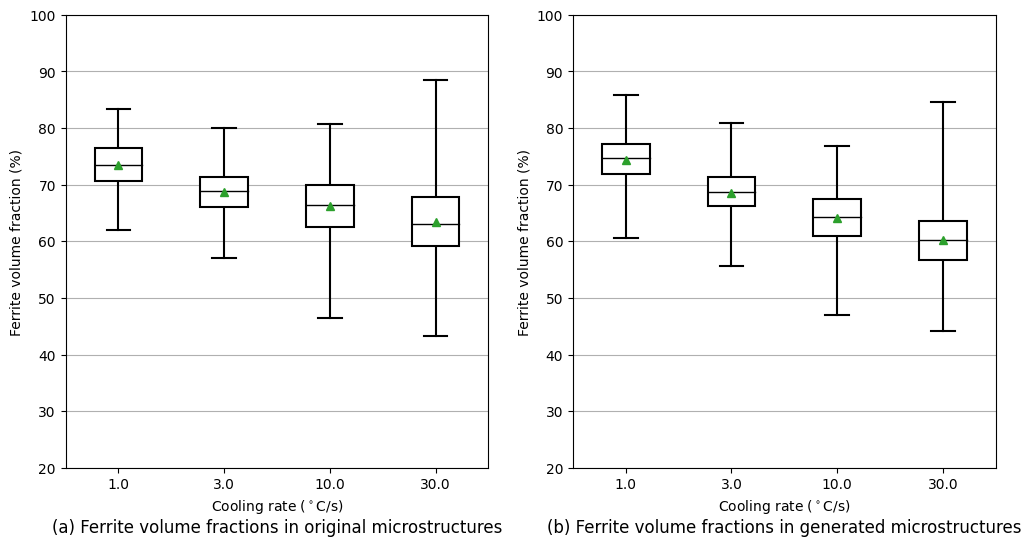



Mean Original 1.0  : 73.442 Variance Original 1.0   :15.837312
Mean Original 3.0  : 68.754 Variance Original 3.0   :13.907466
Mean Original 10.0 : 66.199 Variance Original 10.0  :29.293722
Mean Original 30.0 : 63.428 Variance Original 30.0  :50.306429

Mean Sampled 1.0  : 74.449 Variance Sampled 1.0   :14.909855
Mean Sampled 3.0  : 68.612 Variance Sampled 3.0   :14.277763
Mean Sampled 10.0 : 64.078 Variance Sampled 10.0   :25.763739
Mean Sampled 30.0 : 60.252 Variance Sampled 30.0   :29.9676


In [ ]:
import matplotlib.pyplot as plt
sum_list = np.asarray(sum_list)
sum_list_sample = np.asarray(sum_list_sample)
sum_list0, sum_list1, sum_list2, sum_list3 = np.split(sum_list, 4)
sum_list_sample0, sum_list_sample1, sum_list_sample2, sum_list_sample3 = np.split(sum_list_sample, 4)

data0 = (sum_list0, sum_list1, sum_list2, sum_list3)
data1 = (sum_list_sample0, sum_list_sample1, sum_list_sample2, sum_list_sample3)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
ax1.set_title('(a) Ferrite volume fractions in original microstructures', y=-0.16)
ax1.set_xlabel("Cooling rate ($^\circ$C/s)")
ax1.set_ylabel("Ferrite volume fraction (%)")
ax1.set_xticklabels([1.0, 3.0, 10.0, 30.0])
ax1.set_ylim(20. , 100.)
bp1 = ax1.boxplot(data0, showmeans = True, sym =".", whis = "range" , patch_artist=True)
ax1.yaxis.grid(True)
#ax1.violinplot(data0)

ax2.set_title('(b) Ferrite volume fractions in generated microstructures', y=-0.16)
ax2.set_xlabel("Cooling rate ($^\circ$C/s)")
ax2.set_ylabel("Ferrite volume fraction (%)")
ax2.set_xticklabels([1.0, 3.0, 10.0, 30.0])
ax2.set_ylim(20. , 100.)
bp2 = ax2.boxplot(data1, showmeans = True, sym =".", whis = "range", patch_artist=True)
ax2.yaxis.grid(True)
#ax2.violinplot(data1)

colors1 = ['black', 'black', 'black', 'black']
colors2 = ['white', 'white', 'white', 'white']

bp= [bp1, bp2]

for bplot in bp:
  for patch, color1, color2 in zip(bplot['boxes'], colors1, colors2):
      patch.set(color=color1, linewidth=1.5)
      patch.set_facecolor(color2)
  for patch in bplot['medians']:
      patch.set(color='black' , linewidth=1)
  for patch in bplot['whiskers']:
      patch.set(color='black', linewidth=1.5)
  for patch in bplot['caps']:
      patch.set(color='black', linewidth=1.5)

plt.show()

print("\n")
print("Mean Original 1.0  : "+ str(round(np.average(sum_list0), 3)) +" Variance Original 1.0   :" + str(round(np.var(sum_list0), 6)))
print("Mean Original 3.0  : "+ str(round(np.average(sum_list1), 3)) +" Variance Original 3.0   :" + str(round(np.var(sum_list1), 6)))
print("Mean Original 10.0 : "+ str(round(np.average(sum_list2), 3)) +" Variance Original 10.0  :" + str(round(np.var(sum_list2), 6)))
print("Mean Original 30.0 : "+ str(round(np.average(sum_list3), 3)) +" Variance Original 30.0  :" + str(round(np.var(sum_list3), 6)) + "\n")

print("Mean Sampled 1.0  : "+ str(round(np.average(sum_list_sample0), 3)) + " Variance Sampled 1.0   :" + str(round(np.var(sum_list_sample0), 6)))
print("Mean Sampled 3.0  : "+ str(round(np.average(sum_list_sample1), 3)) + " Variance Sampled 3.0   :" + str(round(np.var(sum_list_sample1), 6)))
print("Mean Sampled 10.0 : "+ str(round(np.average(sum_list_sample2), 3)) + " Variance Sampled 10.0   :" + str(round(np.var(sum_list_sample2), 6)))
print("Mean Sampled 30.0 : "+ str(round(np.average(sum_list_sample3), 3)) + " Variance Sampled 30.0   :" + str(round(np.var(sum_list_sample3), 6)))

Box plot of averaged grain sizes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.


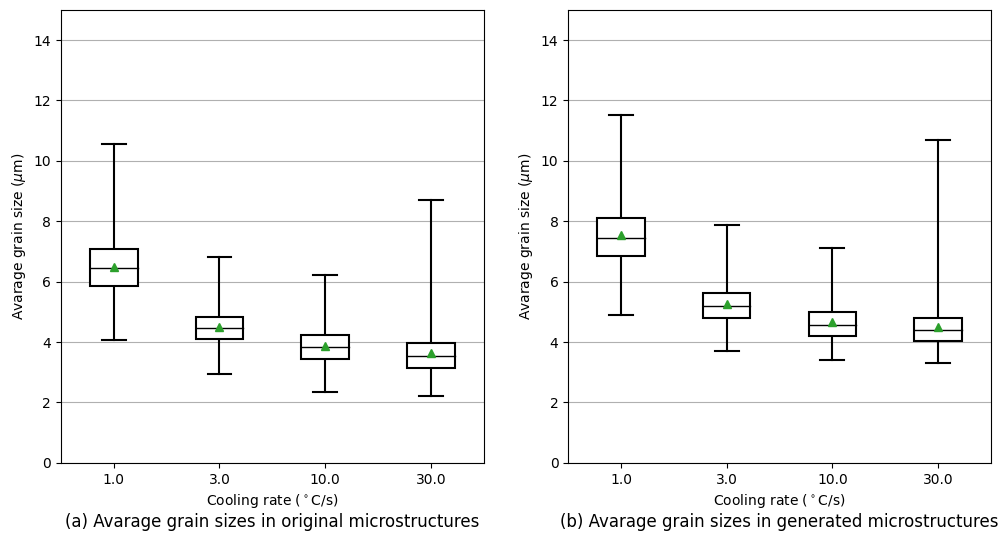

Mean Original 1.0  : 6.498  Mean Sampled 1.0  : 7.544
Mean Original 3.0  : 4.486  Mean Sampled 3.0  : 5.256
Mean Original 10.0 : 3.878  Mean Sampled 10.0 : 4.649
Mean Original 30.0 : 3.641  Mean Sampled 30.0 : 4.502
Variance Original 1.0  : 0.856846 Variance Sampled 1.0   :1.032657
Variance Original 3.0  : 0.345602 Variance Sampled 3.0   :0.398305
Variance Original 10.0 : 0.361463 Variance Sampled 10.0  :0.365117
Variance Original 30.0 : 0.528431 Variance Sampled 30.0  :0.54267


In [ ]:
size_original = np.asarray(size_original)
size_sample = np.asarray(size_sample)
list0, list1, list2, list3 = np.split(size_original, 4)
list_sample0, list_sample1, list_sample2, list_sample3 = np.split(size_sample, 4)

data0 = (list0, list1, list2, list3)
data1 = (list_sample0, list_sample1, list_sample2, list_sample3)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
ax1.set_title('(a) Avarage grain sizes in original microstructures', y=-0.16)
ax1.set_xlabel("Cooling rate ($^\circ$C/s)")
ax1.set_ylabel("Avarage grain size ($\mu$m)")
ax1.set_xticklabels([1.0, 3.0, 10.0, 30.0])
ax1.set_ylim(0. , 15.)
bp1 = ax1.boxplot(data0, showmeans = True, sym =".", whis = "range", patch_artist=True)
ax1.yaxis.grid(True)
#ax1.violinplot(data0)

ax2.set_title('(b) Avarage grain sizes in generated microstructures', y=-0.16)
ax2.set_xlabel("Cooling rate ($^\circ$C/s)")
ax2.set_ylabel("Avarage grain size ($\mu$m)")
ax2.set_xticklabels([1.0, 3.0, 10.0, 30.0])
ax2.set_ylim(0. , 15.)
bp2 = ax2.boxplot(data1, showmeans = True, sym =".", whis = "range", patch_artist=True)
ax2.yaxis.grid(True)
#ax2.violinplot(data1)

colors1 = ['black', 'black', 'black', 'black']
colors2 = ['white', 'white', 'white', 'white']

bp= [bp1, bp2]

for bplot in bp:
  for patch, color1, color2 in zip(bplot['boxes'], colors1, colors2):
      patch.set(color=color1, linewidth=1.5)
      patch.set_facecolor(color2)
  for patch in bplot['medians']:
      patch.set(color='black' , linewidth=1)
  for patch in bplot['whiskers']:
      patch.set(color='black', linewidth=1.5)
  for patch in bplot['caps']:
      patch.set(color='black', linewidth=1.5)


plt.show()

print("Mean Original 1.0  : "+ str(round(np.average(list0), 3)) +"  Mean Sampled 1.0  : "+ str(round(np.average(list_sample0), 3)))
print("Mean Original 3.0  : "+ str(round(np.average(list1), 3)) +"  Mean Sampled 3.0  : "+ str(round(np.average(list_sample1), 3)))
print("Mean Original 10.0 : "+ str(round(np.average(list2), 3)) +"  Mean Sampled 10.0 : "+ str(round(np.average(list_sample2), 3)))
print("Mean Original 30.0 : "+ str(round(np.average(list3), 3)) +"  Mean Sampled 30.0 : "+ str(round(np.average(list_sample3), 3)))

print("Variance Original 1.0  : "+ str(round(np.var(list0), 6)) + " Variance Sampled 1.0   :" + str(round(np.var(list_sample0), 6)))
print("Variance Original 3.0  : "+ str(round(np.var(list1), 6)) + " Variance Sampled 3.0   :" + str(round(np.var(list_sample1), 6)))
print("Variance Original 10.0 : "+ str(round(np.var(list2), 6)) + " Variance Sampled 10.0  :" + str(round(np.var(list_sample2), 6)))
print("Variance Original 30.0 : "+ str(round(np.var(list3), 6)) + " Variance Sampled 30.0  :" + str(round(np.var(list_sample3), 6)))

### Box plot for interpolated cooling rate


In [ ]:
# import image data for 2.0, 6.5, 20.0

import cv2

FOLDER_PATH = 'The folder to store the generated images'

velocity_list = np.zeros(3)
velocity_list[0] = 2.0
velocity_list[1] = 6.5
velocity_list[2] = 20.0
image = []
image_sample = []
image_original2 = []

for velocity in velocity_list:
   x_sample=glob.glob('{}/*.png'.format(FOLDER_PATH))
   
   print(str(velocity)+ " is done")
   ind = 0

   for i in x_sample:
     img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
     image_original2.append(img)
     ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
     
     #print(ind)
     ind += 1
     image_sample.append(img)

image_sample = np.asarray(image_sample)

image_original2 = np.asarray(image_original2)

sum_list_inter =[]

for i in range(image_sample.shape[0]):
    img = image_sample[i]/255.
    sum = np.sum(img)
    sum_list_inter.append((sum/(128*128))*100.)  # white ratio

print(len(sum_list_inter))

2.0 is done
6.5 is done
20.0 is done
3000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  from ipykernel import kernelapp as app


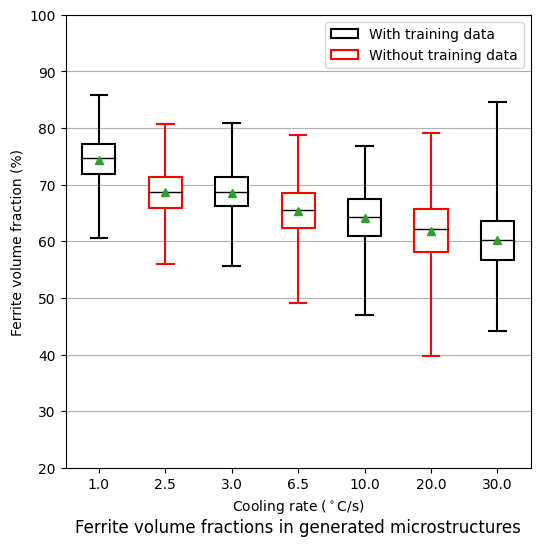

Mean 2.0  : 68.686 Variance 2.0   :15.297024
Mean 6.5  : 65.381 Variance 6.5   :22.066912
Mean 20.0 : 61.899 Variance 20.0  :32.32974


In [ ]:
import matplotlib.pyplot as plt
sum_list_inter = np.asarray(sum_list_inter)
sum_list_inter0, sum_list_inter1, sum_list_inter2 = np.split(sum_list_inter, 3)

data = (sum_list_sample0, sum_list_inter0, sum_list_sample1, sum_list_inter1, sum_list_sample2, sum_list_inter2, sum_list_sample3)

fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
ax1.set_title('Ferrite volume fractions in generated microstructures', y=-0.16)
ax1.set_xlabel("Cooling rate ($^\circ$C/s)")
ax1.set_ylabel("Ferrite volume fraction (%)")
ax1.set_xticklabels([1.0, 2.5, 3.0, 6.5, 10.0, 20.0, 30.0])
ax1.set_ylim(20. , 100.)
ax1.yaxis.grid(True)

bplot = ax1.boxplot(data, showmeans = True, sym =".", whis = "range", patch_artist=True)
#ax1.violinplot(data0)

colors1 = ['black', 'red', 'black', 'red','black', 'red', 'black']
colorsb = ['black', 'black', 'black', 'black', 'black', 'black', 'black']
colors2 = ['white', 'white', 'white', 'white', 'white', 'white', 'white']

colors3 = ['black', 'black', 'red', 'red', 'black', 'black', 'red', 'red', 'black', 'black', 'red', 'red','black', 'black']

for patch, color1, color2 in zip(bplot['boxes'], colors1, colors2):
    patch.set(color=color1, linewidth=1.5)
    patch.set_facecolor(color2)

for patch, c in zip(bplot['medians'], colorsb):
    patch.set(color=c, linewidth=1)

for patch, c in zip(bplot['whiskers'], colors3):
    patch.set(color=c, linewidth=1.5)

for patch, c in zip(bplot['caps'], colors3):
    patch.set(color=c, linewidth=1.5)

ax1.legend([bplot["boxes"][0], bplot["boxes"][1]], ['With training data', 'Without training data'], loc='upper right')

plt.show()

print("Mean 2.0  : "+ str(round(np.average(sum_list_inter0), 3)) + " Variance 2.0   :" + str(round(np.var(sum_list_inter0), 6)))
print("Mean 6.5  : "+ str(round(np.average(sum_list_inter1), 3)) + " Variance 6.5   :" + str(round(np.var(sum_list_inter1), 6)))
print("Mean 20.0 : "+ str(round(np.average(sum_list_inter2), 3)) + " Variance 20.0  :" + str(round(np.var(sum_list_inter2), 6)))

In [ ]:
size_inter = []

cross_point = 0
cross_point2=0
cross_point_tmp=0
index = 0
pixel_length = 0.34

for img in image_sample:
  if index %100 ==0:
    print(str(index) + " is done")

  for i in range(128-1):
    for j in range(128-1):
      if img[i,j]==255 and img[i,j+1]==0:
        cross_point_tmp+=1
      if img[i,j]==0 and img[i,j+1]==255:
        cross_point_tmp+=1
    
    if cross_point_tmp%2 == 1:
      cross_point += (cross_point_tmp+1)/2
    elif img[i,0]==255:
      cross_point += (cross_point_tmp+2)/2
    elif img[i,0]==0:
      cross_point += (cross_point_tmp-2)/2
    cross_point_tmp=0

  for j in range(128-1):
    for i in range(128-1):
      if img[i,j]==255 and img[i+1,j]==0:
        cross_point_tmp+=1
      if img[i,j]==0 and img[i+1,j]==255:
        cross_point_tmp+=1
    
    if cross_point_tmp%2 == 1:
      cross_point2 += (cross_point_tmp+1)/2
    elif img[0,j]==255:
      cross_point2 += (cross_point_tmp+2)/2
    elif img[0,j]==0:
      cross_point2 += (cross_point_tmp-2)/2
    cross_point_tmp=0

  if cross_point+cross_point2==0:
    print("cross_point is zero!")
    size_inter.append(0.)
  else:
    size_inter.append(128*128*(sum_list_inter[index]/100.*pixel_length)*(1/cross_point+1/cross_point2)/2)
  cross_point=0
  cross_point2=0
  index +=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  from ipykernel import kernelapp as app


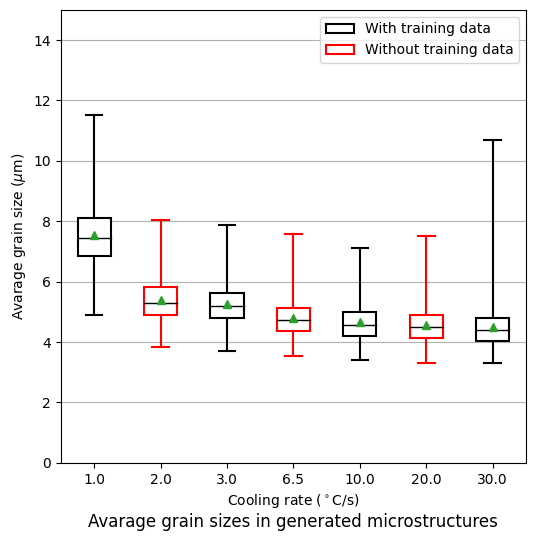

Mean 2.0  : 5.391  Variance 2.0  : 0.484877
Mean 6.5  : 4.801  Variance 6.5  : 0.371046
Mean 20.0 : 4.565  Variance 20.0 : 0.37557


In [ ]:
size_inter = np.asarray(size_inter)
list_inter0, list_inter1, list_inter2 = np.split(size_inter, 3)

data1 = (list_sample0, list_inter0, list_sample1, list_inter1, list_sample2, list_inter2, list_sample3)

fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6), dpi=100)

ax1.set_title('Avarage grain sizes in generated microstructures', y=-0.16)
ax1.set_xlabel("Cooling rate ($^\circ$C/s)")
ax1.set_ylabel("Avarage grain size ($\mu$m)")
ax1.set_xticklabels([1.0, 2.0, 3.0, 6.5, 10.0, 20.0, 30.0])
ax1.set_ylim(0. , 15.)
ax1.yaxis.grid(True)

bplot = ax1.boxplot(data1, showmeans = True, sym =".", whis = "range", patch_artist=True)

colors1 = ['black', 'red', 'black', 'red','black', 'red', 'black']
colorsb = ['black', 'black', 'black', 'black', 'black', 'black', 'black']
colors2 = ['white', 'white', 'white', 'white', 'white', 'white', 'white']

colors3 = ['black', 'black', 'red', 'red', 'black', 'black', 'red', 'red', 'black', 'black', 'red', 'red','black', 'black']

for patch, color1, color2 in zip(bplot['boxes'], colors1, colors2):
    patch.set(color=color1, linewidth=1.5)
    patch.set_facecolor(color2)

for patch, c in zip(bplot['medians'], colorsb):
    patch.set(color=c, linewidth=1)

for patch, c in zip(bplot['whiskers'], colors3):
    patch.set(color=c, linewidth=1.5)

for patch, c in zip(bplot['caps'], colors3):
    patch.set(color=c, linewidth=1.5)

#ax1.violinplot(data1)
ax1.legend([bplot["boxes"][0], bplot["boxes"][1]], ['With training data', 'Without training data'], loc='upper right')
plt.show()

print("Mean 2.0  : "+ str(round(np.average(list_inter0), 3)) +"  Variance 2.0  : "+ str(round(np.var(list_inter0), 6)))
print("Mean 6.5  : "+ str(round(np.average(list_inter1), 3)) +"  Variance 6.5  : "+ str(round(np.var(list_inter1), 6)))
print("Mean 20.0 : "+ str(round(np.average(list_inter2), 3)) +"  Variance 20.0 : "+ str(round(np.var(list_inter2), 6)))